# 0.0. IMPORTS

## 0.1. Python Libraries

In [10]:
import inflection

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import Image

from boruta import BorutaPy
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh

## 0.2. Helper Functions

### 0.2.1. Get Attributes

In [11]:
def get_numerical_attributes(data):
    return data.select_dtypes(include=['int64', 'float64'])

In [12]:
def get_categorical_attributes(data):
    return data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 0.2.2. Get Descriptive Info

In [13]:
def get_descriptive_info(data):
    num_attributes = get_numerical_attributes(data)
    
    # Central Tendency - mean, median
    df_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    df_median = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion - std, min, max, range, skew, kurtosis
    df_std = pd.DataFrame(num_attributes.apply(np.std)).T
    df_min = pd.DataFrame(num_attributes.apply(np.min)).T
    df_max = pd.DataFrame(num_attributes.apply(np.max)).T
    df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    #min, max, range, mean, median, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
    
    df_descriptive_info.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.2.3. Find and Analyze Outliers

In [14]:
def find_and_analyze_outliers(data):
    num_attributes = get_numerical_attributes(data)
    
    Q1 = num_attributes.quantile(0.25)
    Q3 = num_attributes.quantile(0.75)
    IQR = Q3 - Q1
    
    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR
    
    outliers = ((num_attributes < inf_lim) | (num_attributes > sup_lim))
    
    outliers_count = outliers.sum()
    outliers_percentage = (outliers_count / len(num_attributes)) * 100
    
    df_outliers = data[outliers.any(axis=1)]
    
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count' : outliers_count,
        'Outliers Percentage' : outliers_percentage
    })
    
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]
    
    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending = False)
    
    return df_outliers, df_outliers_analyze

### 0.2.4 Plot Univariate Distribution

In [15]:
def plot_univariate_distribution(data):
    num_attributes = get_numerical_attributes(data)
    
    num_rows = round(len(num_attributes.columns)/3)
    num_cols = 3
    
    plt.figure(figsize=(10, 30))
    
    for i, column in enumerate(num_attributes.columns):
        plt.subplot(5, 2, i+1)
        plt.hist(num_attributes[column], density=True, alpha=0.6, color='g')
        
        plt.title(f'Univariate Distribution Plot for  {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        
    plt.tight_layout()
    plt.show()

## 0.3. Loading Data

In [16]:
df_train_raw = pd.read_csv('../data/train.csv', low_memory=False)

# 1.0. DESCRIPTION DATA

In [17]:
df1 = df_train_raw.copy()

In [18]:
df1.sample(5).T

,47528,312077,150168,81871,78484
id,47529,312078,150169,81872,78485
Gender,Female,Male,Female,Male,Female
Age,26,31,42,53,29
Driving_License,1,1,1,1,1
Region_Code,46.0,28.0,33.0,28.0,36.0
Previously_Insured,0,1,0,1,0
Vehicle_Age,< 1 Year,< 1 Year,1-2 Year,1-2 Year,< 1 Year
Vehicle_Damage,Yes,No,Yes,No,Yes
Annual_Premium,32706.0,41303.0,35083.0,45211.0,36462.0
Policy_Sales_Channel,152.0,152.0,124.0,26.0,26.0


## 1.1. Rename Columns

In [19]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [20]:
df1.columns = df1.columns.map(lambda x: inflection.underscore(x))

df1.rename(columns={'vintage':'days_customer_associated'}, inplace=True)

In [21]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'days_customer_associated', 'response'],
      dtype='object')

## 1.2. Data Dimension

In [22]:
print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Features {df1.shape[1]}')

Number of Rows 381109
Number of Features 12


## 1.3. Data Types

In [23]:
df1.dtypes

id                            int64
gender                       object
age                           int64
driving_license               int64
region_code                 float64
previously_insured            int64
vehicle_age                  object
vehicle_damage               object
annual_premium              float64
policy_sales_channel        float64
days_customer_associated      int64
response                      int64
dtype: object

## 1.4. Check NA

In [24]:
df1.isna().sum()

id                          0
gender                      0
age                         0
driving_license             0
region_code                 0
previously_insured          0
vehicle_age                 0
vehicle_damage              0
annual_premium              0
policy_sales_channel        0
days_customer_associated    0
response                    0
dtype: int64

## 1.5. Change Data Types

In [25]:
df1.dtypes

id                            int64
gender                       object
age                           int64
driving_license               int64
region_code                 float64
previously_insured            int64
vehicle_age                  object
vehicle_damage               object
annual_premium              float64
policy_sales_channel        float64
days_customer_associated      int64
response                      int64
dtype: object

## 1.6. Descriptive Info

In [26]:
get_descriptive_info(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,days_customer_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


## 1.7. Check Outliers

In [27]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(df1.drop(columns=['response']))

In [28]:
df_outliers_analyze

,Outliers Count,Outliers Percentage
annual_premium,10320,2.707887
driving_license,812,0.213062


In [29]:
df_outliers

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_customer_associated
25,26,Female,21,1,28.0,1,< 1 Year,No,61964.0,152.0,72
37,38,Female,25,1,28.0,1,< 1 Year,No,76251.0,152.0,107
67,68,Male,60,1,28.0,0,1-2 Year,Yes,66338.0,124.0,73
139,140,Male,21,1,29.0,1,< 1 Year,No,62164.0,152.0,116
149,150,Female,22,1,11.0,1,< 1 Year,No,76651.0,152.0,258
...,...,...,...,...,...,...,...,...,...,...,...
380959,380960,Male,25,1,8.0,1,< 1 Year,No,61909.0,152.0,161
380998,380999,Female,33,1,8.0,0,1-2 Year,Yes,101664.0,124.0,21
381035,381036,Female,22,1,11.0,1,< 1 Year,No,62889.0,152.0,295
381047,381048,Female,52,1,8.0,1,1-2 Year,No,71915.0,7.0,233


# 2.0. FEATURE ENGINEERING

In [30]:
df2 = df1.copy()

In [31]:
df2.sample(5).T

,14853,27151,377448,329266,4808
id,14854,27152,377449,329267,4809
gender,Female,Male,Male,Female,Male
age,28,68,65,23,31
driving_license,1,1,1,1,1
region_code,20.0,17.0,28.0,29.0,46.0
previously_insured,0,0,1,1,0
vehicle_age,1-2 Year,1-2 Year,1-2 Year,< 1 Year,< 1 Year
vehicle_damage,Yes,Yes,No,No,Yes
annual_premium,2630.0,43919.0,2630.0,36295.0,21137.0
policy_sales_channel,156.0,122.0,26.0,152.0,156.0


In [32]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year'  else 'below_1_years')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [33]:
df2.sample(5).T

,94066,24572,316277,42807,354945
id,94067,24573,316278,42808,354946
gender,Male,Male,Female,Female,Male
age,27,26,26,24,24
driving_license,1,1,1,1,1
region_code,52.0,47.0,28.0,25.0,6.0
previously_insured,1,1,1,1,0
vehicle_age,below_1_years,below_1_years,below_1_years,below_1_years,below_1_years
vehicle_damage,0,0,0,0,1
annual_premium,2630.0,37890.0,36564.0,17315.0,30203.0
policy_sales_channel,152.0,152.0,152.0,152.0,152.0


# 3.0. VARIABLE FILTERING

In [34]:
df3 = df2.copy()

In [35]:
df3.sample(5).T

,105832,40374,41426,58834,130968
id,105833,40375,41427,58835,130969
gender,Female,Female,Male,Female,Female
age,41,22,31,65,35
driving_license,1,1,1,1,1
region_code,8.0,49.0,8.0,28.0,0.0
previously_insured,0,0,0,0,0
vehicle_age,between_1_2_years,below_1_years,below_1_years,between_1_2_years,between_1_2_years
vehicle_damage,1,1,1,1,1
annual_premium,2630.0,14785.0,43121.0,29241.0,29694.0
policy_sales_channel,156.0,152.0,160.0,26.0,124.0


# 4.0. EXPLORATORY DATA ANALYSIS

In [36]:
df4 = df3.copy()

In [37]:
df4.sample(5).T

,111296,95319,83859,22790,92187
id,111297,95320,83860,22791,92188
gender,Female,Female,Female,Male,Male
age,28,24,48,30,38
driving_license,1,1,1,1,1
region_code,8.0,8.0,3.0,28.0,8.0
previously_insured,1,1,1,1,0
vehicle_age,below_1_years,below_1_years,between_1_2_years,below_1_years,between_1_2_years
vehicle_damage,0,0,0,0,1
annual_premium,37340.0,39277.0,2630.0,2630.0,46416.0
policy_sales_channel,152.0,152.0,122.0,152.0,152.0


## 4.1. Univariate Analysis

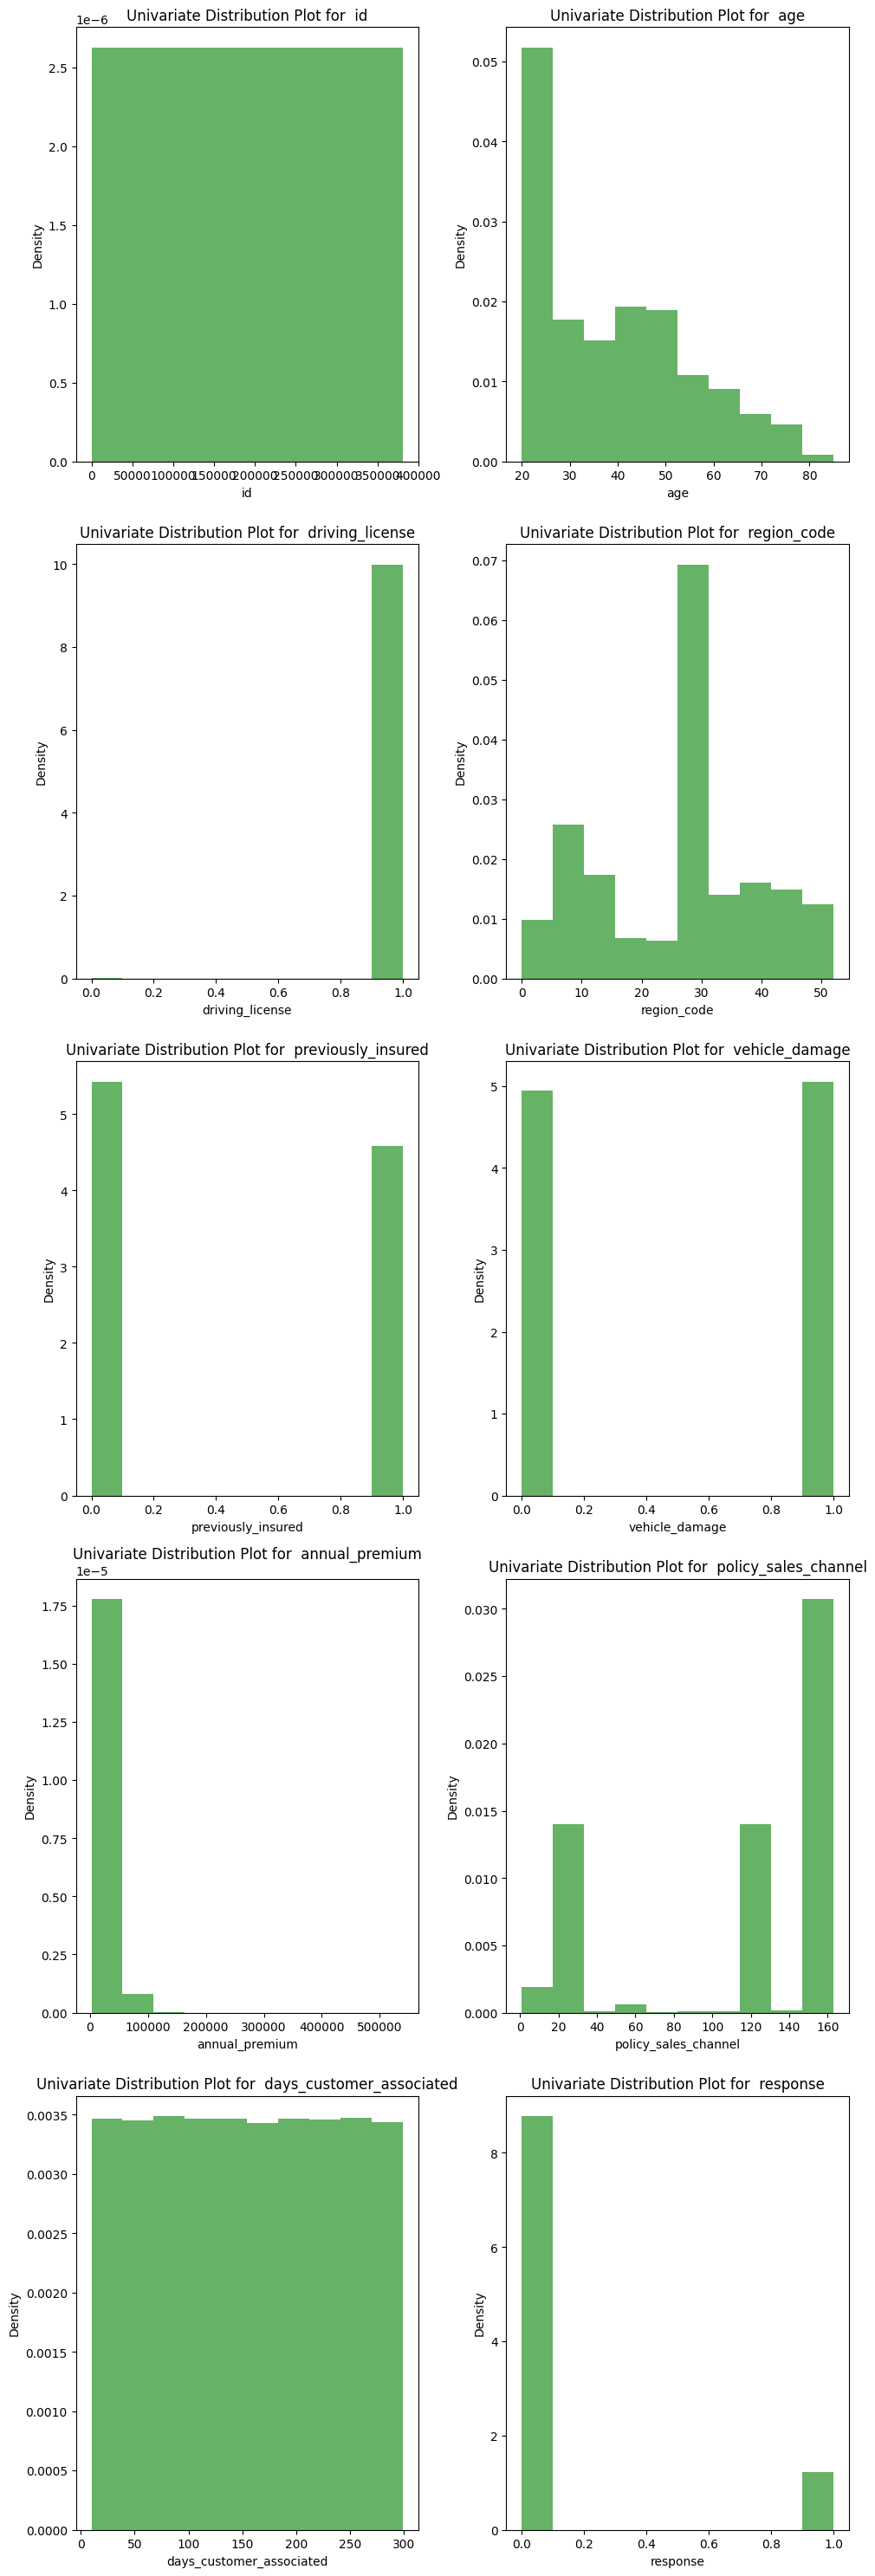

In [38]:
plot_univariate_distribution(df4)

## 4.2. Bivariate Analysis

### 4.2.1. Gender

In [39]:
# 'gender'
df4[['gender', 'response']].head()

,gender,response
0,Male,1
1,Male,0
2,Male,1
3,Male,0
4,Female,0


In [40]:
# 'gender'
pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


### 4.2.2. Age

<Axes: xlabel='response', ylabel='age'>

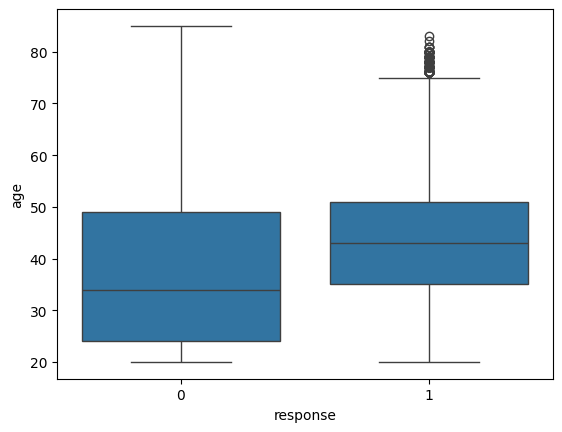

In [41]:
# 'age'
sns.boxplot(x='response', y='age',data=df4)

<Axes: xlabel='age', ylabel='Count'>

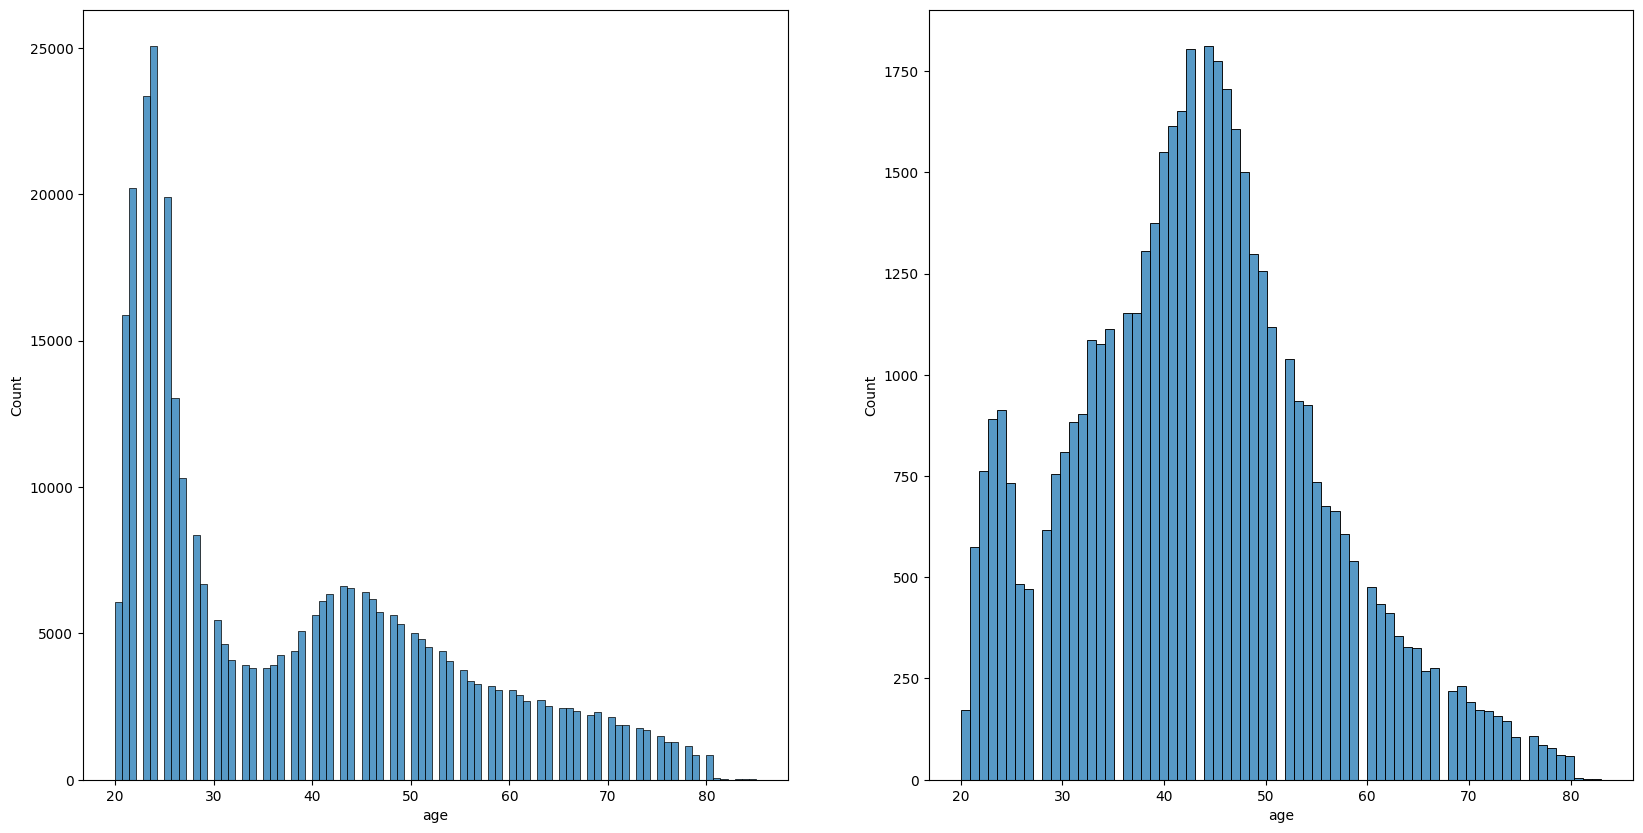

In [42]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

plt.subplot(1, 2, 2)
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux01)

### 4.2.3. Driving License

In [43]:
# 'driving_license'
df4[['driving_license', 'response']].head()

,driving_license,response
0,1,1
1,1,0
2,1,1
3,1,0
4,1,0


In [44]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='response', ylabel='driving_license'>

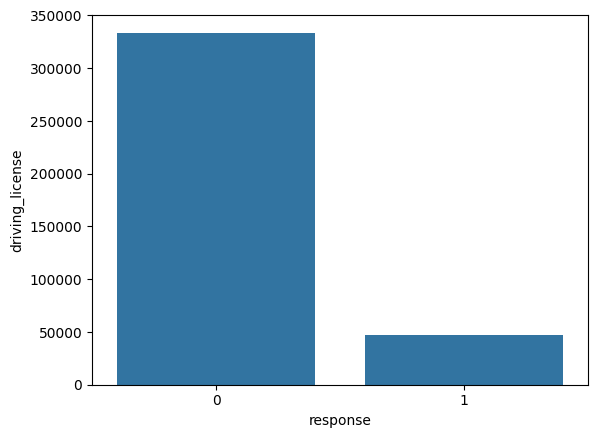

In [45]:
sns.barplot(x='response', y='driving_license', data=aux)

### 4.2.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

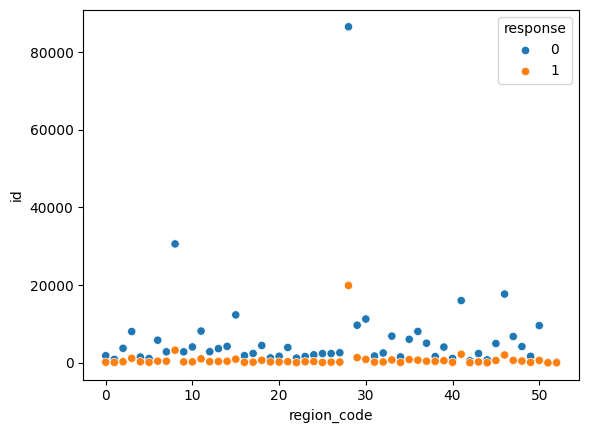

In [46]:
# 'region_code'
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

### 4.2.5. Previously Insured

In [47]:
# 'previously_insured'
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.2.6. Vehicle Age

In [48]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_years,0,0.434285
1,below_1_years,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_years,1,0.018897
5,over_2_years,1,0.012338


### 4.2.7. Vehicle Damage

In [49]:
# 'vehicle_damage'
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### 4.2.8. Annual Premium

<Axes: xlabel='response', ylabel='annual_premium'>

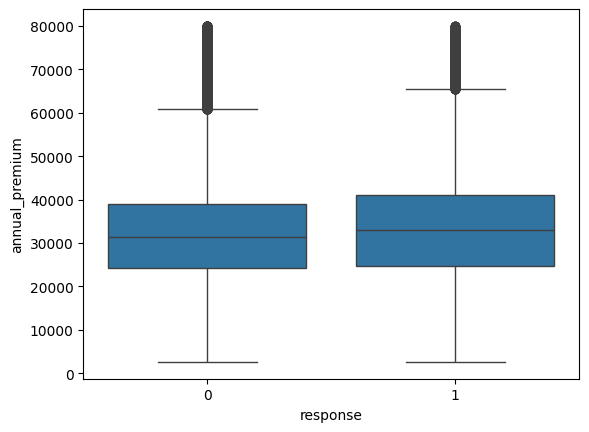

In [50]:
# 'annual_premium'
aux = df4[df4['annual_premium'] < 80000]

sns.boxplot(x='response', y='annual_premium', data=aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

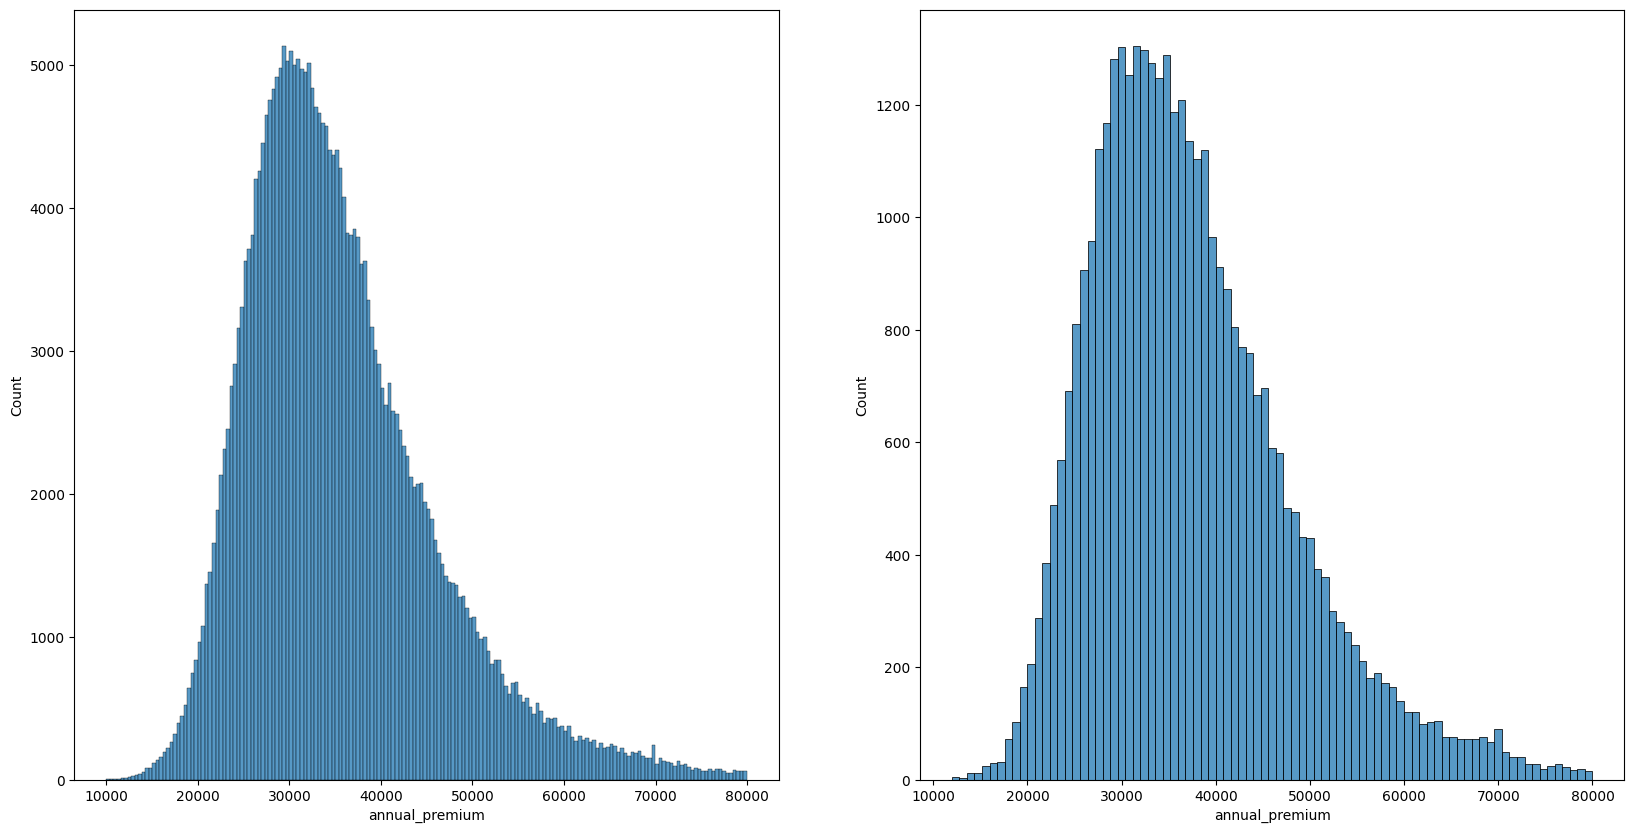

In [51]:
plt.figure(figsize=(20, 10))

aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1, 2, 1)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

plt.subplot(1, 2, 2)
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux01)

### 4.2.9. Policy Sales Channel

<Axes: xlabel='response', ylabel='policy_sales_channel'>

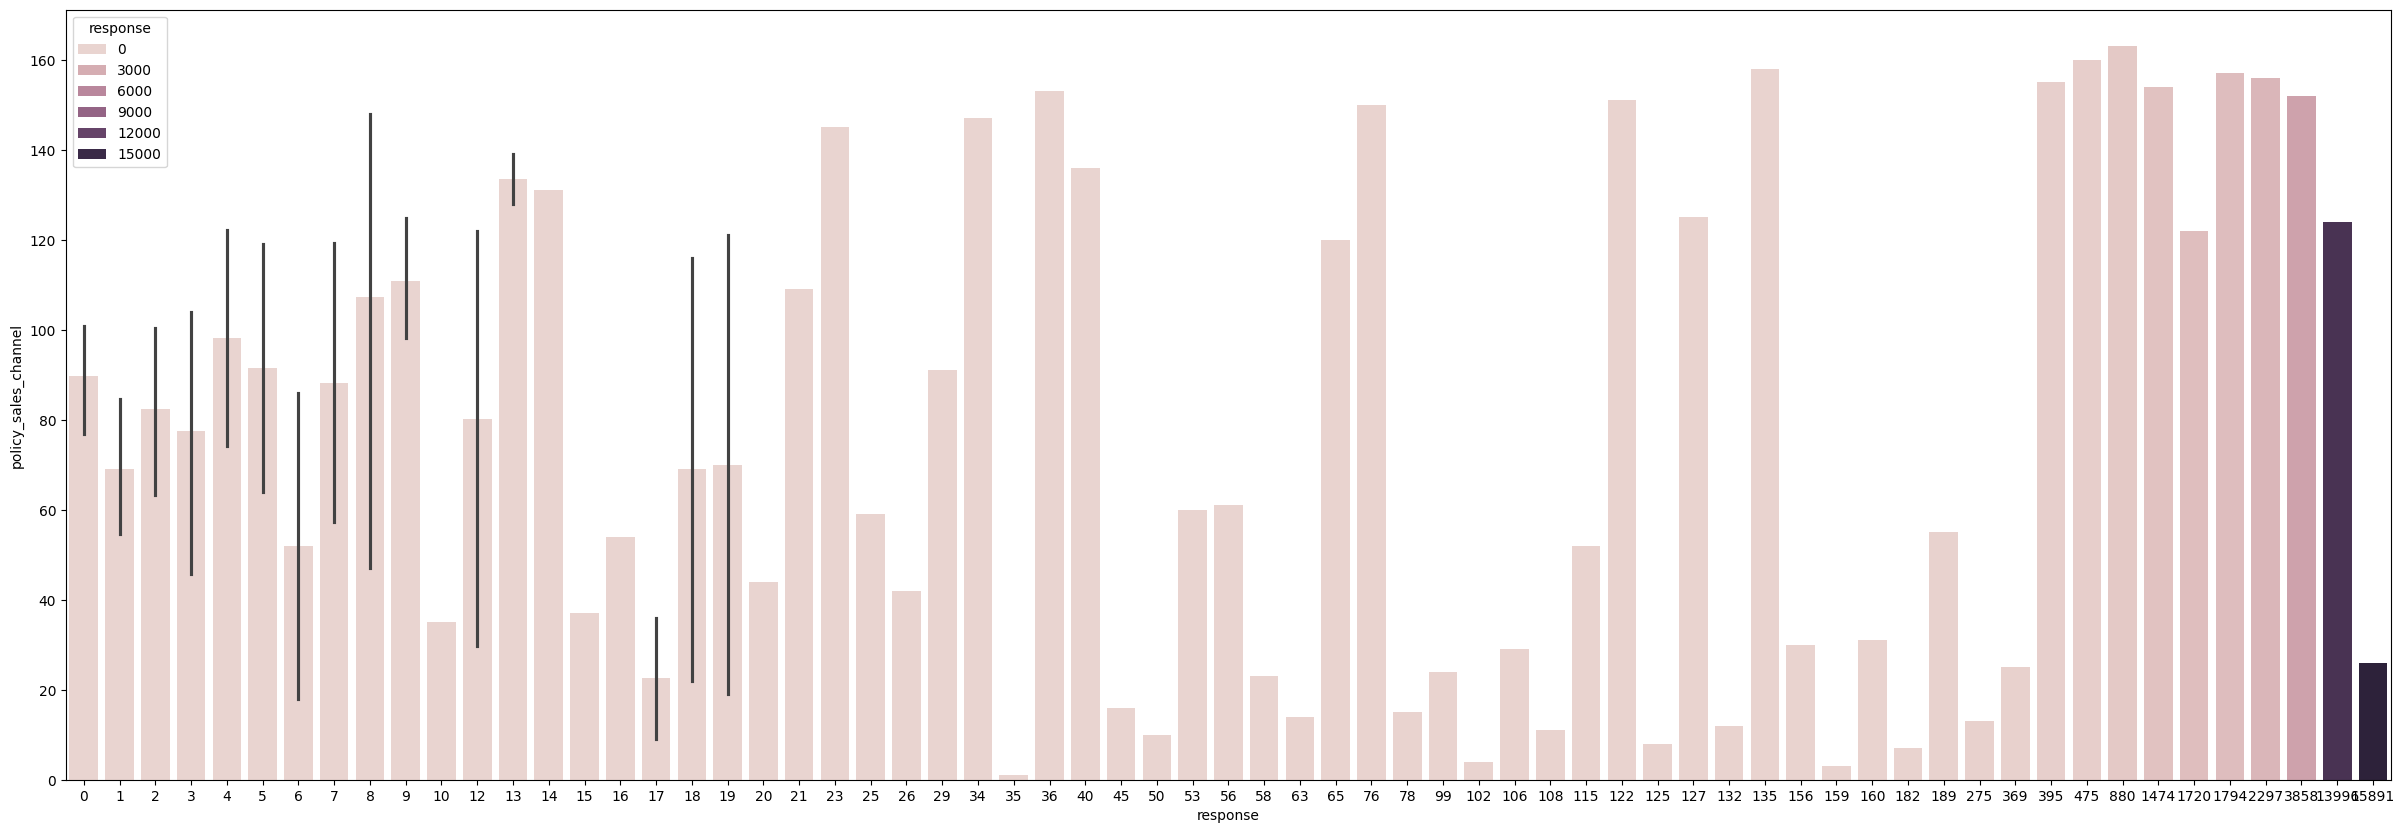

In [52]:
# 'policy_sales_channel'
plt.figure(figsize=(30, 10))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', hue='response', data=aux)

### 4.2.10. Days Customer Associated

<Axes: xlabel='response', ylabel='days_customer_associated'>

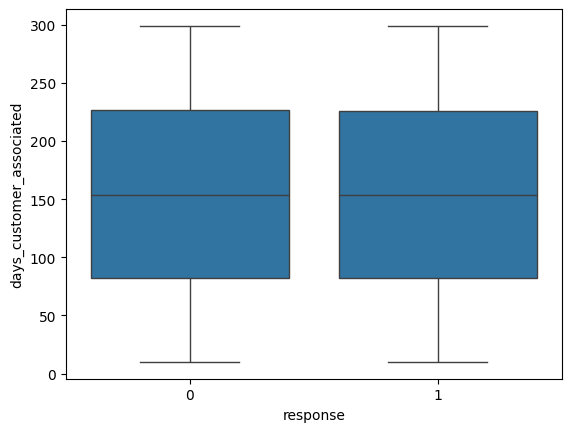

In [53]:
# 'days_customer_associated'
sns.boxplot(x='response', y='days_customer_associated', data=df4)

<Axes: xlabel='days_customer_associated', ylabel='Count'>

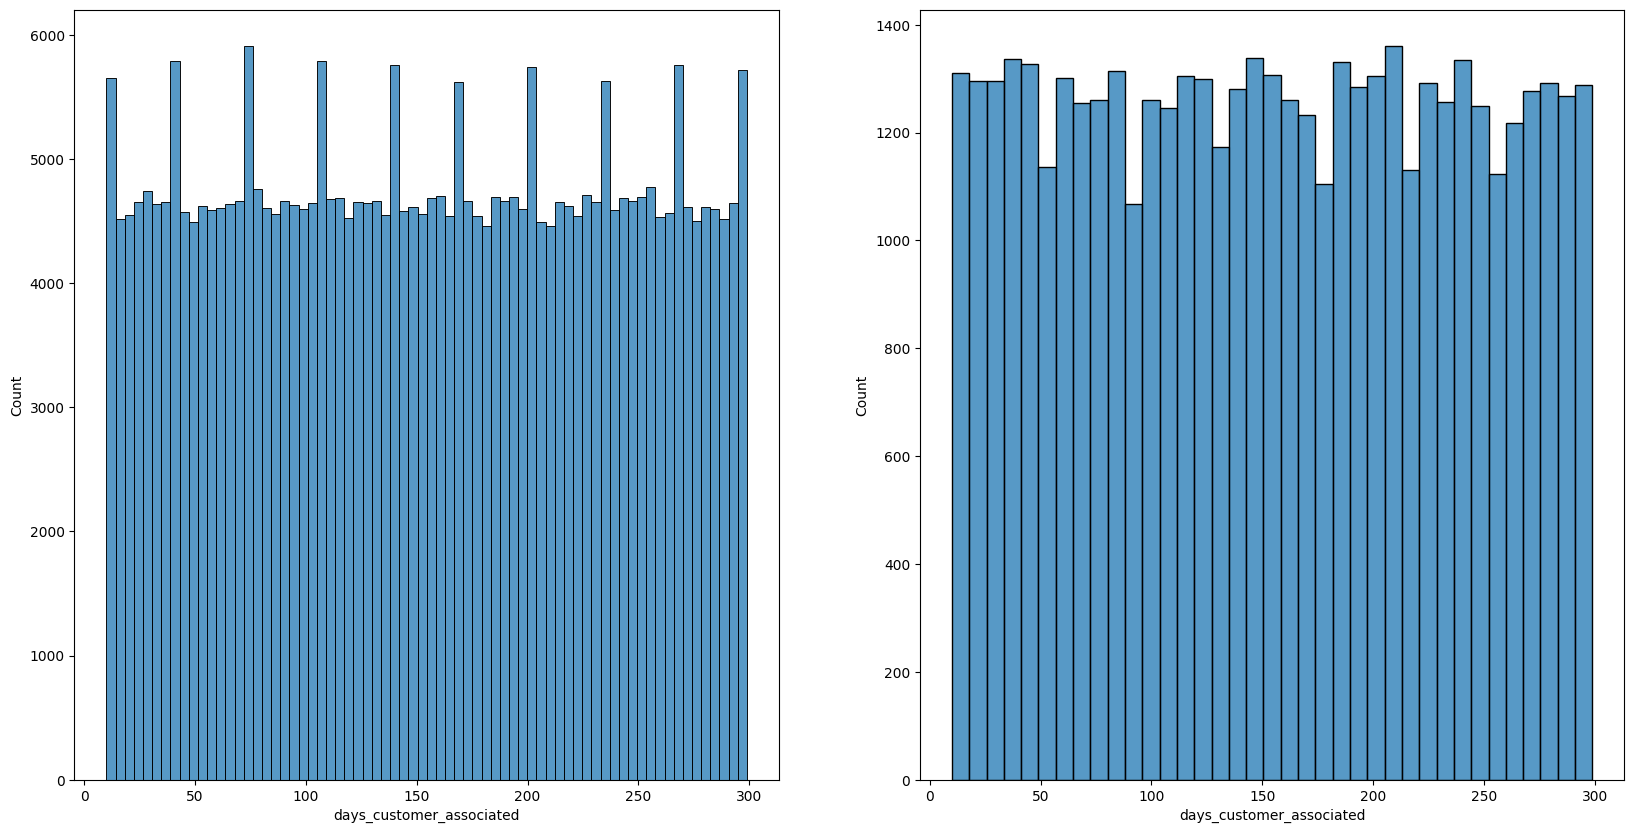

In [54]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'days_customer_associated']
sns.histplot(aux00)

plt.subplot(1, 2, 2)
aux01 = df4.loc[df4['response'] == 1, 'days_customer_associated']
sns.histplot(aux01)

# 5.0. Data Preparation

In [55]:
df5 = df4.copy()

In [56]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

In [57]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2. Rescaling

In [58]:
mms_age = pp.MinMaxScaler()
mms_days_customer_associated = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# days_customer_associated
df5['days_customer_associated'] = mms_days_customer_associated.fit_transform(df5[['days_customer_associated']].values)

## 5.3. Encoder

### 5.3.1. region_code

The feature indicates a state. But as it has a large number of possibilities (i.e. more than 6), disqualifying **One Hot Encoding**. This leaves the following possibilities:

1. Target Encoding
2. Frequency Encoding
3. Weighted Target Encoding

In [59]:
# indicates whether or not the customer has a state, but with must possibility
df5['region_code'].unique()

array([28., 15., 23., 14., 29.,  8.,  0., 41., 26., 39., 32., 38., 13.,
        3., 10., 33., 37., 50., 30., 46.,  6., 22., 35., 45.,  7., 18.,
       12.,  4., 27., 34.,  9., 24., 11., 48., 43., 47., 21.,  2., 36.,
       40., 16., 42., 25., 51., 20.,  5., 31., 19., 17., 44., 49.,  1.,
       52.])

In [60]:
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

### 5.3.2. vehicle_age

The feature indicate a state, but with an implicit order of magnitude. This leaves the following possibilities:

1. Order Encoding
2. One Hot Encoding / Get Dummies
3. Frequency Encoding

In [61]:
df5['vehicle_age'].unique()

array(['below_1_years', 'between_1_2_years', 'over_2_years'], dtype=object)

In [62]:
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

### 5.3.3. policy_sales_channel

The feature indicates a state. But as it has a large number of possibilities (i.e. more than 6), disqualifying **One Hot Encoding**. This leaves the following possibilities:

1. Target Encoding
2. Frequency Encoding

In [63]:
df5['policy_sales_channel'].unique()

array([122.,  26., 124., 152., 151., 156.,  35.,  47., 160.,   1., 154.,
        11., 157.,   8.,  55.,   7.,  13.,  86.,  92., 158.,  31.,  25.,
         4., 127.,  30., 155.,  22., 108.,  60., 163., 113., 153.,  24.,
        12.,  52., 128.,  14.,  93.,  64.,   9.,   3., 131.,  23., 120.,
        29.,  18., 138., 109., 125., 114., 121.,  15.,  91., 139.,  19.,
       116., 136., 111.,  94.,  16., 147.,  61.,  51.,  53., 133., 150.,
        42., 119., 130., 104.,  73.,  59.,  21., 149., 144., 159., 140.,
        10.,  17., 107., 148., 145.,  39.,  44.,  90.,  54.,  37., 132.,
        89.,  97.,  20., 129., 146.,  36.,  48.,  63., 135., 118.,  88.,
       106., 126.,  80.,  45.,  78.,  40.,  62.,  81.,  57.,  87.,  49.,
        58.,  69., 137.,  65.,  56.,  43.,  32.,  70.,  68., 134., 110.,
         6., 103.,  71.,  98.,  66., 100.,  34.,  99.,  67.,  96.,  46.,
        83., 102.,  38., 101.,  28.,  33.,  50.,  95.,  76., 117.,  82.,
         2., 105.,  79.,  84.,  27., 112.,  74., 12

In [64]:
frequency_encode_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size()/len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(frequency_encode_policy_sales_channel)

### 5.3.4. gender

The feature indicates a state, but as it has a small number of possibilities. This leaves the following possibilities:

1. One Hot Encoding
2. Target Encoding

In [65]:
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

## 5.4. Validation Preparation

In [66]:
# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map(frequency_encode_policy_sales_channel)

# days_customer_associated
x_val.loc[:, 'days_customer_associated'] = mms_days_customer_associated.transform(x_val[['days_customer_associated']].values)

# fillna
x_val = x_val.fillna(0)

# 6.0. Feature Selection

In [67]:
df6 = df5.copy()

## 6.1. Boruta

In [68]:
# model definition
rf = en.RandomForestRegressor(n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [69]:
cols_selected = boruta.support_.tolist()

x_train_feature_selected = df6.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_feature_selected.iloc[:, cols_selected].columns.tolist()

cols_selected_boruta

['vehicle_damage']

## 6.2. Extra Tree Classifier

In [70]:
# model definition
forest = en.ExtraTreesClassifier (n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Raking:
                         feature  importance
0       days_customer_associated    0.271455
0                 annual_premium    0.243761
0                            age    0.166549
0                    region_code    0.104280
0                 vehicle_damage    0.069289
0           policy_sales_channel    0.061095
0             previously_insured    0.055713
0      vehicle_age_below_1_years    0.014017
0  vehicle_age_between_1_2_years    0.006231
0                         gender    0.004943
0       vehicle_age_over_2_years    0.002193
0                driving_license    0.000472


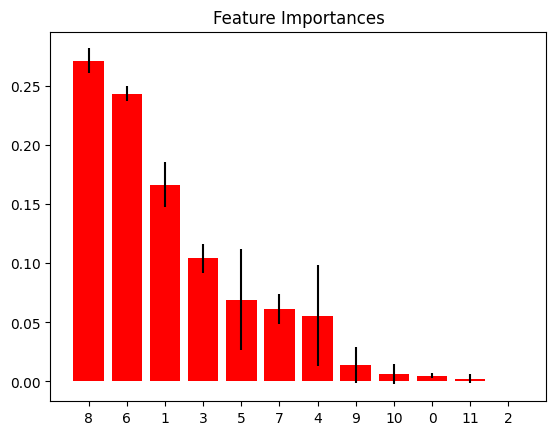

In [71]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature raking
print('Feature Raking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim((-1, x_train_n.shape[1]))
plt.show()

# 7.0. Machine Learning

In [72]:
df7 = df6.copy()

In [73]:
cols_selected = ['days_customer_associated', 
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']

x_train = df5[cols_selected]
x_val = x_val[cols_selected]

## 7.1. KNN

In [74]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=3)

# model training
knn_model.fit(x_train, y_train)

# model prediction - generalize
yhat_knn = knn_model.predict_proba(x_val)